# Traditional Machine Learning ModelS

### Feature Extraction

In [ ]:
import json
import os
import librosa
import numpy as np
from scipy.signal import butter, sosfilt
import sys

# Dataset Path
BASE_DATASET_PATH = "C:/Users/ndaru/OneDrive - KFUPM/THESIS/DATASET/MAN/ALL COMBINED V2"

# The extracted features are splitted into three JSON files: training, validation, testing
JSON_TRAIN_PATH = "train_MFCC_dur3.json"
JSON_VALIDATION_PATH = "validation_MFCC_dur3.json"
JSON_TEST_PATH = "test_MFCC_dur3.json"

# MFCC parameter
SAMPLE_RATE = 22050
TRACK_DURATION = 3  # in seconds
SAMPLES_PER_TRACK = int(SAMPLE_RATE * TRACK_DURATION)

# Creating a function for filtering 250-2000 Hz
def bandpass_filter(signal, sr, lowcut=250, highcut=2000, order=5):

    sos = butter(order, [lowcut, highcut], btype='band', fs=sr, output='sos')
    return sosfilt(sos, signal)

# Creating a function for extracting MFCC from datasets
def process_files(base_path, split_name, num_mfcc=32, n_fft=2048, hop_length=128):

    mapping = []
    labels = []
    mfcc_left_list = []
    mfcc_right_list = []
    
    class_dirs = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])
    
    for i, class_dir in enumerate(class_dirs):
        semantic_label = class_dir
        if split_name == "training":
            mapping.append(semantic_label)
        print(f"\nProcessing: {semantic_label} -> {split_name}")
        
        dirpath = os.path.join(base_path, class_dir, split_name)

        if not os.path.isdir(dirpath):
            print(f"Directory not found, skipping: {dirpath}")
            continue
            
        filenames = [f for f in os.listdir(dirpath) if f.lower().endswith(('.wav', '.mp3', '.flac'))]

        for f in filenames:
            file_path = os.path.join(dirpath, f)
            try:
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE, mono=False)

                if signal.shape[0] != 2:
                    print(f"Skipping non-stereo file: {file_path}")
                    continue

                # Adding paddings for datasets that are below 3 seconds
                if signal.shape[1] < SAMPLES_PER_TRACK:
                    pad_length = SAMPLES_PER_TRACK - signal.shape[1]
                    signal = np.pad(signal, ((0, 0), (0, pad_length)), mode="constant")
                elif signal.shape[1] > SAMPLES_PER_TRACK:
                    signal = signal[:, :SAMPLES_PER_TRACK]

                left_channel = bandpass_filter(signal[0], sample_rate)
                right_channel = bandpass_filter(signal[1], sample_rate)

                mfcc_left = librosa.feature.mfcc(y=left_channel, sr=sample_rate,
                                                 n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length).T
                mfcc_right = librosa.feature.mfcc(y=right_channel, sr=sample_rate,
                                                  n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length).T
                
                mfcc_left_list.append(mfcc_left)
                mfcc_right_list.append(mfcc_right)
                labels.append(i)
                print(f"Loaded file: {file_path}")

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    if not mapping:
        mapping = class_dirs

    return mapping, labels, mfcc_left_list, mfcc_right_list

# Creating a function for normalizing training datasets
def save_normalized_data(json_path, mapping, labels, mfcc_left_list, mfcc_right_list, mean_l, std_l, mean_r, std_r):
    
    data = {"mapping": mapping, "labels": labels, "mfcc_left": [], "mfcc_right": []}
    
    for mfcc_l, mfcc_r in zip(mfcc_left_list, mfcc_right_list):
        norm_mfcc_l = (mfcc_l - mean_l) / (std_l + 1e-10)
        norm_mfcc_r = (mfcc_r - mean_r) / (std_r + 1e-10)
        
        data["mfcc_left"].append(norm_mfcc_l.tolist())
        data["mfcc_right"].append(norm_mfcc_r.tolist())
        
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
    print(f"\nDatasets are successfully saved in {json_path}")

# Running all functions that have made
if __name__ == "__main__":
    print("="*30)
    print("PROCESSING THE TRAINING DATASET")
    print("="*30)
    train_mapping, train_labels, train_mfcc_l, train_mfcc_r = process_files(BASE_DATASET_PATH, "training")

    if not train_mfcc_l:
        print("\n\nERROR: No training dataset has been successfully uploaded.")
        sys.exit()

    print("\nCalculating normalization")
    stacked_left = np.vstack(train_mfcc_l)
    mean_left = np.mean(stacked_left, axis=0)
    std_left = np.std(stacked_left, axis=0)

    stacked_right = np.vstack(train_mfcc_r)
    mean_right = np.mean(stacked_right, axis=0)
    std_right = np.std(stacked_right, axis=0)
    print("Normalization has been successfully calculated.")

    save_normalized_data(JSON_TRAIN_PATH, train_mapping, train_labels, train_mfcc_l, train_mfcc_r,
                         mean_left, std_left, mean_right, std_right)
                         
    print("\n" + "="*30)
    print("PROCESSING THE VALIDATION DATASET")
    print("="*30)
    _, val_labels, val_mfcc_l, val_mfcc_r = process_files(BASE_DATASET_PATH, "validation")
    save_normalized_data(JSON_VALIDATION_PATH, train_mapping, val_labels, val_mfcc_l, val_mfcc_r,
                         mean_left, std_left, mean_right, std_right)

    print("\n" + "="*30)
    print("PROCESSING THE TESTING DATASET")
    print("="*30)
    _, test_labels, test_mfcc_l, test_mfcc_r = process_files(BASE_DATASET_PATH, "testing")
    save_normalized_data(JSON_TEST_PATH, train_mapping, test_labels, test_mfcc_l, test_mfcc_r,
                         mean_left, std_left, mean_right, std_right)

### Model Development

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from pycaret.classification import *

# Defining the JSON files
BASE_PATH = 'C:/Users/ndaru/OneDrive - KFUPM/THESIS/DATASET'
JSON_TRAIN_PATH = os.path.join(BASE_PATH, 'train_MFCC_dur3.json')
JSON_VALIDATION_PATH = os.path.join(BASE_PATH, 'validation_MFCC_dur3.json')
JSON_TEST_PATH = os.path.join(BASE_PATH, 'test_MFCC_dur3.json')

# Creating a function for loading and creating dataframe
def load_and_create_dataframe(json_path):
   
    print(f"Processing file: {json_path}...")
    
    if not os.path.exists(json_path):
        print(f"ERROR: File is not found in '{json_path}'.")
        return None

    with open(json_path, 'r') as f:
        data = json.load(f)

    mapping = data['mapping']
    labels = data['labels']
    mfcc_left_data = data['mfcc_left']
    mfcc_right_data = data['mfcc_right']

    records = []
    for i in range(len(labels)):
        label_name = mapping[labels[i]]
        mfcc_left = np.array(mfcc_left_data[i]).flatten()
        mfcc_right = np.array(mfcc_right_data[i]).flatten()
        features = np.concatenate([mfcc_left, mfcc_right])
        row = {'label': label_name}
        row.update({f'feat_{j}': val for j, val in enumerate(features)})
        records.append(row)

    df = pd.DataFrame(records)
    print(f"✅ Finish. Dataframe Dimension: {df.shape}")
    return df


if __name__ == "__main__":
    
    train_df = load_and_create_dataframe(JSON_TRAIN_PATH)
    validation_df = load_and_create_dataframe(JSON_VALIDATION_PATH)
    test_df = load_and_create_dataframe(JSON_TEST_PATH)

    if train_df is None or validation_df is None or test_df is None:
        print("\nThe process is stopped as the data can be identified")
    else:
        combined_train_df = pd.concat([train_df, validation_df], ignore_index=True)

        print(f"Dataframe Dimension for Training Dataset: {combined_train_df.shape}")
        print(f"Dataframe Dimension for Testing Dataset: {test_df.shape}")

        print("\nLaunching PyCaret...")
        clf_setup = setup(
            data=combined_train_df, 
            test_data=test_df, 
            target='label', 
            session_id=123,
            index=False, 
            verbose=True
        )

        print("\nComparing the models...")
        best_model = compare_models()
        print("\nThe best model has found:")
        print(best_model)

        # Save the model
        model_filename = 'MFCC Trad Models'
        save_model(best_model, model_filename)

# Deep Learning Model (CNN)

### Feature Extraction

In [ ]:
import json
import os
import librosa
import numpy as np
from scipy.signal import butter, sosfilt
import sys

# Dataset path
BASE_DATASET_PATH = r"C:\Users\ndaru\OneDrive - KFUPM\THESIS\DATASET\MAN\ALL COMBINED V2"

# The extracted features are splitted into three JSON files: training, validation, testing
TRAIN_JSON_PATH = "train_MFCC_CNN_dur3.json"
VALIDATION_JSON_PATH = "validation_MFCC_CNN_dur3.json"
TEST_JSON_PATH = "test_MFCC_CNN_dur3.json"

# Defining Parameters
SAMPLE_RATE = 22050
TRACK_DURATION = 3  # in seconds
SAMPLES_PER_TRACK = int(SAMPLE_RATE * TRACK_DURATION)
NUM_MFCC = 32
N_FFT = 2048
HOP_LENGTH = 128

# Creating a function for filtering 250-2000 Hz
def bandpass_filter(signal, sr, lowcut=250, highcut=2000, order=5):
    
    sos = butter(order, [lowcut, highcut], btype='band', fs=sr, output='sos')
    return sosfilt(sos, signal)

# Creating a function for extracting MFCC from datasets
def process_data(base_path, class_mappings, splits_to_process):

    all_data = {split: {"labels": [], "mfcc_left": [], "mfcc_right": []} for split in splits_to_process}

    for label_index, class_name in enumerate(class_mappings):
        print(f"\nProcessing Class: {class_name} (Label: {label_index})")
        
        for split_name in splits_to_process:
            split_path = os.path.join(base_path, class_name, split_name)
            
            if not os.path.isdir(split_path):
                print(f"  -> Directory is not found, pass: {split_path}")
                continue
            
            print(f"  -> Split Processing: {split_name}")

            for f in sorted(os.listdir(split_path)):
                if not f.lower().endswith(('.wav', '.mp3', '.flac')):
                    continue
                    
                file_path = os.path.join(split_path, f)
                
                try:
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE, mono=False)

                    if signal.shape[0] != 2:
                        print(f"     -> Passing non-stereo file: {f}")
                        continue

                    # Adding paddings for datasets that are below 3 seconds
                    if signal.shape[1] < SAMPLES_PER_TRACK:
                        pad_length = SAMPLES_PER_TRACK - signal.shape[1]
                        signal = np.pad(signal, ((0, 0), (0, pad_length)), mode="constant")
                    elif signal.shape[1] > SAMPLES_PER_TRACK:
                        signal = signal[:, :SAMPLES_PER_TRACK]

                    left_channel = bandpass_filter(signal[0], sample_rate)
                    right_channel = bandpass_filter(signal[1], sample_rate)

                    mfcc_left = librosa.feature.mfcc(y=left_channel, sr=sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH).T
                    mfcc_right = librosa.feature.mfcc(y=right_channel, sr=sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH).T

                    all_data[split_name]["mfcc_left"].append(mfcc_left)
                    all_data[split_name]["mfcc_right"].append(mfcc_right)
                    all_data[split_name]["labels"].append(label_index)

                except Exception as e:
                    print(f"     -> Failed to load file {f}. Error: {e}")

    return all_data

# Creating a fucntion for saving the JSON file
def save_to_json(data, json_path, class_mappings):
    data_to_save = {
        "mapping": class_mappings,
        "labels": data["labels"],
        "mfcc_left": [mfcc.tolist() for mfcc in data["mfcc_left"]],
        "mfcc_right": [mfcc.tolist() for mfcc in data["mfcc_right"]]
    }
    with open(json_path, "w") as fp:
        json.dump(data_to_save, fp, indent=4)
    print(f"\nData has been saved in {json_path}")

if __name__ == "__main__":
    try:
        class_mappings = sorted([d for d in os.listdir(BASE_DATASET_PATH) if os.path.isdir(os.path.join(BASE_DATASET_PATH, d))])
        if not class_mappings:
            raise FileNotFoundError
    except FileNotFoundError:
        print(f"❌ ERROR: No folder class found in: {BASE_DATASET_PATH}")
        print("Ensure the path contains folder 'High Intelligibility' dan 'Low Intelligibility'.")
        sys.exit()

    print(f"Class detected: {class_mappings}")

    splits = ["training", "validation", "testing"]
    processed_data = process_data(BASE_DATASET_PATH, class_mappings, splits)

    train_data = processed_data["training"]
    validation_data = processed_data["validation"]
    test_data = processed_data["testing"]

    # Calculating normalization..
    all_train_mfcc_left = np.vstack(train_data["mfcc_left"])
    all_train_mfcc_right = np.vstack(train_data["mfcc_right"])
    
    mean_left = np.mean(all_train_mfcc_left, axis=0)
    std_left = np.std(all_train_mfcc_left, axis=0)
    mean_right = np.mean(all_train_mfcc_right, axis=0)
    std_right = np.std(all_train_mfcc_right, axis=0)

    epsilon = 1e-10
    for split_name in splits:
        current_data = processed_data[split_name]
        current_data["mfcc_left"] = [(mfcc - mean_left) / (std_left + epsilon) for mfcc in current_data["mfcc_left"]]
        current_data["mfcc_right"] = [(mfcc - mean_right) / (std_right + epsilon) for mfcc in current_data["mfcc_right"]]
    
    print("\nNormalization for training dataset has been successfullt calculated.")

    # Saving the JSON file
    save_to_json(train_data, TRAIN_JSON_PATH, class_mappings)
    save_to_json(validation_data, VALIDATION_JSON_PATH, class_mappings)
    save_to_json(test_data, TEST_JSON_PATH, class_mappings)
    
    print("\n✅ Process is over.")

### Model Development

Uploading data from: C:\Users\ndaru\OneDrive - KFUPM\THESIS\DATASET\train_MFCC_CNN_dur3.json
  -> Shape X: (220, 517, 32, 2, 1), Shape Y: (220,)
  -> Label: [0 1]
Uploading data from: C:\Users\ndaru\OneDrive - KFUPM\THESIS\DATASET\validation_MFCC_CNN_dur3.json
  -> Shape X: (94, 517, 32, 2, 1), Shape Y: (94,)
  -> Label: [0 1]
Uploading data from: C:\Users\ndaru\OneDrive - KFUPM\THESIS\DATASET\test_MFCC_CNN_dur3.json
  -> Shape X: (56, 517, 32, 2, 1), Shape Y: (56,)
  -> Label: [0 1]


C:\Users\ndaru\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_31 (Conv3D)                   │ (None, 517, 32, 2, 16)      │             496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 517, 32, 2, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout3d_30                 │ (None, 517, 32, 2, 16)      │               0 │
│ (SpatialDropout3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_30 (MaxPooling3D)      │ (None, 172, 10, 1, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_32 (Conv3D)                   │ (None, 172, 10, 1, 32)      │           7,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 172, 10, 1, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout3d_31                 │ (None, 172, 10, 1, 32)      │               0 │
│ (SpatialDropout3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_31 (MaxPooling3D)      │ (None, 57, 3, 1, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 5472)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 128)                 │         700,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 709,202 (2.71 MB)

 Trainable params: 709,106 (2.71 MB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.4979 - loss: 1.6048 - learning_rate: 1.0000e-04
Epoch 2/100


C:\Users\ndaru\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
C:\Users\ndaru\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
C:\Users\ndaru\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\model_checkpoint.py:302: UserWarning: Can save best model only with val_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.6300 - loss: 0.8247 - learning_rate: 1.0000e-04
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.5511 - loss: 0.9261 - learning_rate: 1.0000e-04
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.6520 - loss: 0.7259
Epoch 4: val_accuracy improved from -inf to 0.54255, saving model to CNN_MFCC_best_model.weights.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.6523 - loss: 0.7258 - val_accuracy: 0.5426 - val_loss: 0.6786 - learning_rate: 1.0000e-04
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.6098 - loss: 0.7731 - learning_rate: 1.0000e-04
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.7074 - loss: 0.5859 - learning_rate: 1.0000e-04
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.6579 - loss: 0.6775 - learning_rate: 1.0000e-04
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7232 - loss: 0.6317
Epoch 8: val_accur

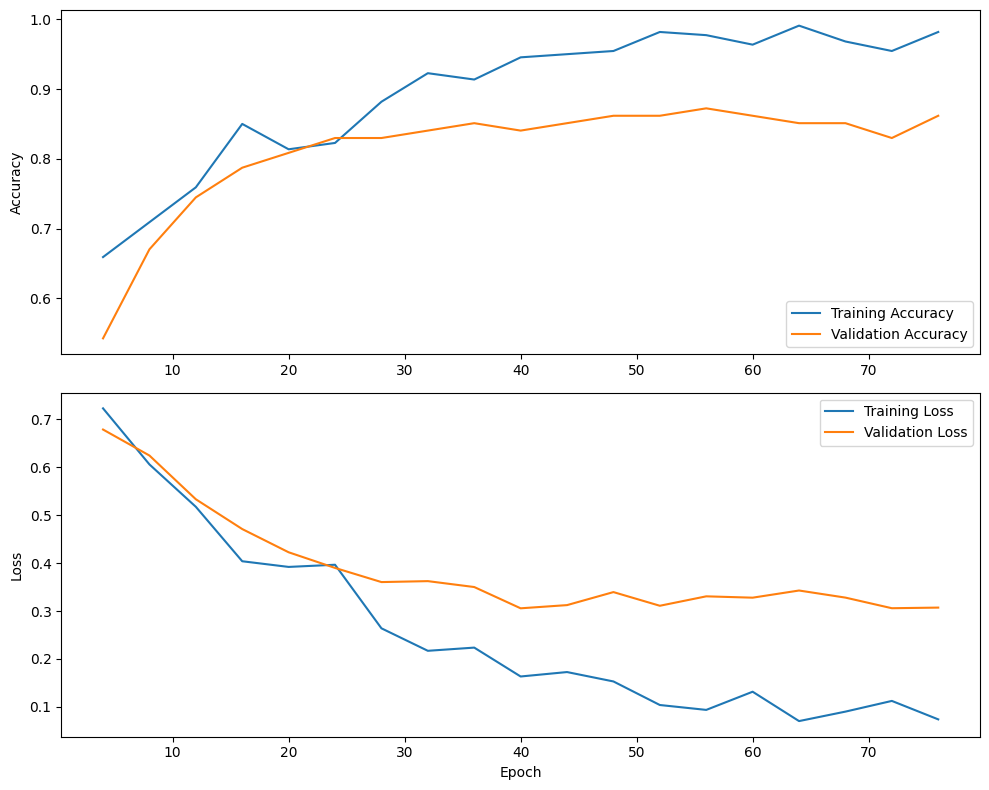


--- Evaluating Model ---
2/2 - 0s - 213ms/step - accuracy: 0.8571 - loss: 0.5811

Accuracy: 0.8571
Loss: 0.5811
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step


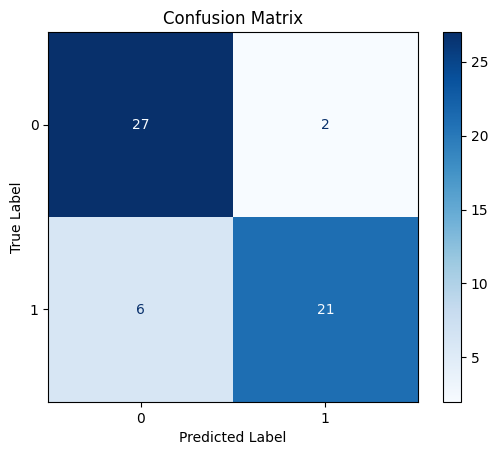

In [31]:
import json
import os
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Importing the JSON files
BASE_PATH = r"C:\Users\ndaru\OneDrive - KFUPM\THESIS\DATASET"
TRAIN_JSON_PATH = os.path.join(BASE_PATH, "train_MFCC_CNN_dur3.json")
VALIDATION_JSON_PATH = os.path.join(BASE_PATH, "validation_MFCC_CNN_dur3.json")
TEST_JSON_PATH = os.path.join(BASE_PATH, "test_MFCC_CNN_dur3.json")

# Creating a dunction for loadind dataset
def load_data_from_file(data_path):
   
    print(f"Uploading data from: {data_path}")
    with open(data_path, "r") as fp:
        data = json.load(fp)

    mfcc_left = np.array(data["mfcc_left"])
    mfcc_right = np.array(data["mfcc_right"])
    y = np.array(data["labels"])
    
    mask = (y == 2) | (y == 3)
    
    X_unfiltered = np.stack((mfcc_left, mfcc_right), axis=-1)
    
    X_filtered = X_unfiltered[mask]
    y_filtered = y[mask]

    y_remapped = y_filtered.copy()
    y_remapped[y_filtered == 2] = 0
    y_remapped[y_filtered == 3] = 1

    X = X_filtered[..., np.newaxis]
    y = y_remapped

    print(f"  -> Shape X: {X.shape}, Shape Y: {y.shape}")
    print(f"  -> Label: {np.unique(y)}")
    return X, y

# Creating a plot for ploting accuracy and loss
def plot_history(history, validation_freq=1):
    
    import numpy as np

    train_acc  = np.array(history.history["accuracy"])
    train_loss = np.array(history.history["loss"])
    val_acc    = np.array(history.history.get("val_accuracy", []))
    val_loss   = np.array(history.history.get("val_loss", []))

    epochs = np.arange(1, len(train_acc) + 1)

    if validation_freq > 1 and len(val_acc) > 0:
        val_epochs = np.arange(validation_freq, len(train_acc) + 1, validation_freq)
        train_acc  = train_acc[val_epochs - 1]
        train_loss = train_loss[val_epochs - 1]
        epochs     = val_epochs

    fig, axs = plt.subplots(2, figsize=(10, 8))

    axs[0].plot(epochs, train_acc, label="Training Accuracy")
    if len(val_acc):
        axs[0].plot(epochs, val_acc, label="Validation Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")

    axs[1].plot(epochs, train_loss, label="Training Loss")
    if len(val_loss):
        axs[1].plot(epochs, val_loss, label="Validation Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

# Creating a function for building model
def build_model(input_shape):

    model = Sequential()
    
    model.add(Conv3D(filters=16, kernel_size=(5, 3, 2), activation='relu', input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(SpatialDropout3D(0.3))
    model.add(MaxPooling3D(pool_size=(3, 3, 2)))
    
    model.add(Conv3D(filters=32, kernel_size=(5, 3, 1), activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), padding='same'))
    model.add(BatchNormalization())
    model.add(SpatialDropout3D(0.3))
    model.add(MaxPooling3D(pool_size=(3, 3, 1)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))

    return model


if __name__ == "__main__":

    X_train, y_train = load_data_from_file(TRAIN_JSON_PATH)
    X_validation, y_validation = load_data_from_file(VALIDATION_JSON_PATH)
    X_test, y_test = load_data_from_file(TEST_JSON_PATH)

    input_shape = X_train.shape[1:]
    model = build_model(input_shape)

    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    
    # Tambahkan ini sebelum training
    checkpoint_path = "CNN_MFCC_best_model.weights.h5"
    model_checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose=1
    )
    
    # EarlyStopping berdasarkan akurasi validasi, bukan loss
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,  # berhenti jika val_accuracy stagnan/turun 5 kali berturut-turut
        restore_best_weights=True,
        mode='max',
        verbose=1
    )
    
    # Learning rate scheduler tetap
    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        mode='max',
        verbose=1
    )
    
    # Mulai training dengan validasi setiap 4 epoch
    history = model.fit(
        X_train, y_train,
        validation_data=(X_validation, y_validation),
        batch_size=8,
        epochs=100,
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1,
        validation_freq=4  # validasi setiap 4 epoch
    )

    model.load_weights(checkpoint_path)
    plot_history(history, validation_freq=4)

    print("\n--- Evaluating Model ---")
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f'\nAccuracy: {test_acc:.4f}')
    print(f'Loss: {test_loss:.4f}')

    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs[:, 1] > 0.5).astype(int) 
    
    # Calculating confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    labels = np.unique(y_test)
    
    # Visualizing the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()